In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold 

In [2]:
df = pd.read_csv("./data/measurements.csv", decimal=',')

In [3]:
# ダミー変数
df['gas_type'] = pd.get_dummies(df['gas_type'])
df['specials'] = pd.get_dummies(df['specials'])
# 欠損値を平均で埋める
df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].mean())
# 目的変数と説明変数の設定
target = df['consume']
data = df.loc[:, ['distance', "speed", 'temp_inside' , 'temp_outside', 'gas_type', 'specials', 'AC', 'rain', 'sun']]

In [5]:
# 交差検証
def cross_validation(data, target, clf, n_split):
    cross_valid_mse,cross_valid_rmse, cross_valid_mae = 0,0,0
    
    for train, test in KFold(n_splits=n_split, shuffle=True, random_state=111).split(data, target):
        data_train, target_train = data.iloc[train], target[train]
        data_test, target_test = data.iloc[test], target[test]
        clf.fit(data_train, target_train)

        predicted_target = clf.predict(data_test)
        
         # 平均二乗誤差 (MSE)
        cross_valid_mse += metrics.mean_squared_error(target_test, predicted_target)
        # 二乗平均平方根誤差 (RMSE)
        cross_valid_rmse += np.sqrt(metrics.mean_squared_error(target_test, predicted_target))
        # 平均絶対誤差 (MAE)
        cross_valid_mae += metrics.mean_absolute_error(target_test, predicted_target)
    mse = cross_valid_mse / n_split
    rmse = cross_valid_rmse / n_split
    mae = cross_valid_mae / n_split
    return {"MSE":mse, "RMSE":rmse, "MAE":mae}

In [6]:
clf = linear_model.LinearRegression(fit_intercept=True)

In [7]:
# 手動で精度を検証
print("k=5", cross_validation(data, target, clf, 5))
print("k=10", cross_validation(data, target, clf, 10))
print("k=50", cross_validation(data, target, clf, 50))
print("k=100", cross_validation(data, target, clf, 100))
print("k=200", cross_validation(data, target, clf, 200))

k=5 {'MSE': 0.9063960130510713, 'RMSE': 0.9460838216793297, 'MAE': 0.640977822161328}
k=10 {'MSE': 0.8988125522731384, 'RMSE': 0.9122947265099427, 'MAE': 0.6364269452677899}
k=50 {'MSE': 0.8835682729285999, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228034}
k=100 {'MSE': 0.8848129284926175, 'RMSE': 0.7778682207704496, 'MAE': 0.6359339601213999}
k=200 {'MSE': 0.8866898410742773, 'RMSE': 0.7133418317725929, 'MAE': 0.6377328876003883}


In [8]:
# そのまま
as_it_is = cross_validation(data, target, clf, 50)
print(as_it_is)

{'MSE': 0.8835682729285999, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228034}


In [9]:
# 標準化
std_data = (data - data.mean()) / data.std()
std = cross_validation(std_data, target, clf, 50)
print(std)

{'MSE': 0.8835682729286001, 'RMSE': 0.8321495384147597, 'MAE': 0.6342443148228033}


In [10]:
# 0~1に正規化
normalized_data = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
normalize = cross_validation(normalized_data, target, clf, 50)
print(normalize)

{'MSE': 0.8835682729286001, 'RMSE': 0.8321495384147596, 'MAE': 0.6342443148228033}


In [11]:
# 正則化項のグリッドサーチ
def crossvalidation_with_gridsearch(data, target, n_split, lasso_or_ridge, range_searching_list):
    result_list = []
    for alpha in range_searching_list:
        if lasso_or_ridge == "lasso":
            clf = linear_model.Lasso(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        elif lasso_or_ridge == "ridge":
            clf = linear_model.Ridge(alpha=alpha, fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
        result = cross_validation(data, target, clf, n_split)
        result_list.append([alpha, result['RMSE']])
#         print(alpha, result) # 経過が見たかったらコメントをはずす
    sorted_result_list = sorted(result_list, key=lambda x: x[1])
    print("RMSE最小のalpha", sorted_result_list[0][0])
    
    if lasso_or_ridge == "lasso":
        clf = linear_model.Lasso(alpha=sorted_result_list[0][0], fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
    elif lasso_or_ridge == "ridge":
        clf = linear_model.Ridge(alpha=sorted_result_list[0][0], fit_intercept=True, copy_X=True, max_iter=1000, tol=0.0001,random_state=111)
    
    return cross_validation(data, target, clf, n_split)

In [12]:
# L1正則化

range_searching_list = np.arange(0.01, 1.01, 0.01)

# そのまま
lasso = crossvalidation_with_gridsearch(data, target, 50, "lasso", range_searching_list)
# 標準化
std_lasso = crossvalidation_with_gridsearch(std_data, target, 50, "lasso", range_searching_list)
# 0~1に正規化
normalized_lasso = crossvalidation_with_gridsearch(normalized_data, target, 50, "lasso", range_searching_list)

RMSE最小のalpha 0.02
RMSE最小のalpha 0.08
RMSE最小のalpha 0.02


In [13]:
lasso_mse_list = [lasso['MSE'], std_lasso['MSE'], normalized_lasso['MSE']]
lasso_rmse_list = [lasso['RMSE'], std_lasso['RMSE'], normalized_lasso['RMSE']]
lasso_mae_list = [lasso['MAE'], std_lasso['MAE'], normalized_lasso['MAE']]

result = pd.DataFrame([lasso_mse_list, lasso_rmse_list, lasso_mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化"]
display(result)


,MSE,RMSE,MAE
そのまま,0.885530,0.826352,0.627107
標準化,0.894164,0.818137,0.616935
正規化,0.902621,0.819880,0.617466


In [14]:
# L2正則化

range_searching_list = np.arange(0.01, 2.01, 0.1)

# そのまま
ridge = crossvalidation_with_gridsearch(data, target, 50, "ridge", range_searching_list)
# 標準化
std_ridge = crossvalidation_with_gridsearch(std_data, target, 50, "ridge", range_searching_list)
# 0~1に正規化
normalized_ridge = crossvalidation_with_gridsearch(normalized_data, target, 50, "ridge", range_searching_list)

RMSE最小のalpha 1.9100000000000001
RMSE最小のalpha 1.9100000000000001
RMSE最小のalpha 1.9100000000000001


In [15]:
ridge_mse_list = [ridge['MSE'], std_ridge['MSE'], normalized_ridge['MSE']]
ridge_rmse_list = [ridge['RMSE'], std_ridge['RMSE'], normalized_ridge['RMSE']]
ridge_mae_list = [ridge['MAE'], std_ridge['MAE'], normalized_ridge['MAE']]

result = pd.DataFrame([ridge_mse_list, ridge_rmse_list, ridge_mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化"]
display(result)

,MSE,RMSE,MAE
そのまま,0.881754,0.830516,0.632764
標準化,0.883262,0.831760,0.633797
正規化,0.879856,0.825025,0.624772


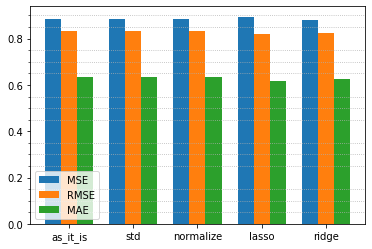

In [16]:
# 手法ごとに精度を描画
mse_list = [as_it_is['MSE'], std['MSE'], normalize['MSE'], std_lasso['MSE'], normalized_ridge['MSE']]
rmse_list = [as_it_is['RMSE'], std['RMSE'], normalize['RMSE'], std_lasso['RMSE'], normalized_ridge['RMSE']]
mae_list = [as_it_is['MAE'], std['MAE'], normalize['MAE'], std_lasso['MAE'], normalized_ridge['MAE']]
 
left = np.arange(len(mse_list))
labels = ['as_it_is', 'std', 'normalize', 'lasso', 'ridge']

width = 0.25
 
plt.bar(left, mse_list, width=width, align='center', label="MSE")
plt.bar(left+width, rmse_list, width=width, align='center', label="RMSE")
plt.bar(left+width*2, mae_list, width=width, align='center', label="MAE")

plt.legend(loc='lower left')
plt.xticks(left + width, labels)
plt.gca().yaxis.set_minor_locator(tick.MultipleLocator(0.05))
plt.grid(linestyle='dotted', which='minor')
plt.show()

In [17]:
# 精度の表
result = pd.DataFrame([mse_list, rmse_list, mae_list], index=["MSE", "RMSE", "MAE"]).T
result.index = ["そのまま","標準化","正規化", "L1正則化", "L2正則化"]
pd.options.display.precision = 16
display(result)


,MSE,RMSE,MAE
そのまま,0.8835682729285999,0.8321495384147597,0.6342443148228034
標準化,0.8835682729286001,0.8321495384147597,0.6342443148228033
正規化,0.8835682729286001,0.8321495384147596,0.6342443148228033
L1正則化,0.8941644098240156,0.8181371279510660,0.6169350297246752
L2正則化,0.8798555505508416,0.8250248958702336,0.6247717299443412


In [18]:
# それぞれの指標での最小値とその手法
pd.concat([result.idxmin(), result.min()], axis=1)

,0,1
MSE,L2正則化,0.8798555505508416
RMSE,L1正則化,0.8181371279510660
MAE,L1正則化,0.6169350297246752
